In [37]:
## import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import ray
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn


/Users/vostolaza/opt/anaconda3/envs/bigdata-2022-2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ray.init(num_cpus=10)

2022-11-10 18:00:41,632	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.13
Ray version:,2.0.0
Dashboard:,http://127.0.0.1:8265


In [26]:
#ray.shutdown()

In [3]:
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

train_path = "CASIA_faceAntisp/train_release"

dim = 128

In [56]:
@ray.remote
def get_training_subject(path, samples_per_video):
    real_videos = ['1.avi', '2.avi', 'HR_1.avi', 'HR_4.avi']
    subject = []
    target = []
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    for dir in os.listdir(os.path.join(path)):
        cap = cv2.VideoCapture(os.path.join(path, dir))
        resampling_rate = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / samples_per_video)
        count = 0
        failed = False
        crops = []
        entry = []
        while cap.isOpened():
            success, img = cap.read()
            if failed or success and count%resampling_rate == 0:
                faces = face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1.1, 4)
                if len(faces) != 1:
                    failed = True
                    continue
                (x, y, w, h) = faces[0]
                entry.append(cv2.resize(img[y:y+h,x:x+w], dsize=(dim,dim)))
                failed = False
            else:
                break
            count += 1
        subject.append(torch.Tensor(entry[0]))
        target.append(1 if dir in real_videos else 0)
    return subject, target

def read_training_files(path, samples_per_video=16):
    features = []
    targets = []
    for person in tqdm(os.listdir(path)):
        f, t = ray.get(get_training_subject.remote(os.path.join(path,person), samples_per_video))
        features += f
        targets += t
    return features, targets

In [57]:
train_features, train_targets = read_training_files(train_path, samples_per_video=16)

100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


In [ ]:
for feature, val in zip(train_features, train_targets):
    for frame in feature:
        display(val)
        display(Image.fromarray(frame))
#         break

In [46]:
model = nn.Sequential(nn.Linear(128*128*3, 15),
                      nn.ReLU(),
                      nn.Linear(15, 1),
                      nn.Sigmoid())

In [47]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [62]:
train_features = torch.stack(train_features)

In [65]:
train_features.shape

torch.Size([240, 128, 128, 3])

In [71]:
losses = []
outputs = []
for epoch in range(1000):
    for i in range(len(train_features)):
        optimizer.zero_grad()
        output = model(train_features[i].view(-1, 128*128*3))
        outputs.append(output)
        loss = loss_function(output, torch.Tensor([train_targets[i]]))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

/Users/vostolaza/opt/anaconda3/envs/bigdata-2022-2/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
outputs

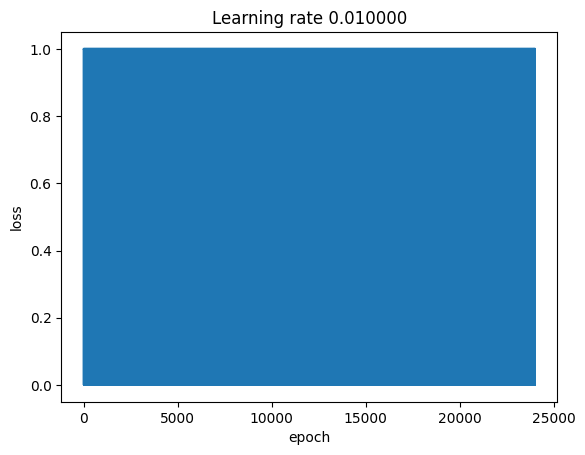

In [70]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(0.01))
plt.show()